# Tutorial 12: Visualization

## Overview
In this tutorial we are going to cover:

* [Image Visualization](#t12ImageVisualization)
    * [ImageDisplay](#t12ImageDisplay)
    * [BatchDisplay](#t12BatchDisplay)
    * [GridDisplay](#t12GridDisplay)
    * [DisplayTraces](#t12DisplayTraces)

### Preliminary Setup

Before we experience the visualization features offered by FastEstimator, let's take care of some imports and dataset definitions:

In [1]:
import warnings

import numpy as np
import torch

import fastestimator as fe

from fastestimator.dataset.data import montgomery

from fastestimator.op.numpyop import Batch
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import ChannelTranspose, ReadImage, Minmax, Binarize
from fastestimator.op.numpyop import Delete

from fastestimator.architecture.pytorch import UNet
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.trace.metric import Dice

from fastestimator.util import BatchDisplay, GridDisplay, ImageDisplay
from fastestimator.trace.io.batch_display import BatchDisplay as BatchDisplayTrace
from fastestimator.trace.io.grid_display import GridDisplay as GridDisplayTrace

from skimage import measure

warnings.filterwarnings('ignore')


In [2]:
class CombineLeftRightMask(fe.op.numpyop.NumpyOp):
    def forward(self, data, state):
        mask_left, mask_right = data
        dt1 = np.concatenate((mask_left,mask_right),axis=-1)
        return dt1
    
class BoundingBoxKeypoint(fe.op.numpyop.NumpyOp):
    def __init__(self, inputs, outputs, margin=0, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.margin = margin

    def forward(self, data, state):
        y_true = data
        if len(y_true.shape)==2:
            y_true = np.expand_dims(y_true, axis=-1)
        channels = y_true.shape[-1]
        
        box_cord = []
        keypoints_final = []
        
        for ch in range(channels):
            cord, keypoints = self.binary2boxcoords(y_true[:,:,ch],ch)
            if len(cord) > 0:
                cord = np.vstack(cord)
                keypoints = np.vstack(keypoints)
            else:
                cord = np.empty((0, 5))
                keypoints = np.empty((0, 2))
            box_cord.extend(cord)
            keypoints_final.extend(keypoints)
            
        return np.array(box_cord), np.array(keypoints_final)
        
    def binary2boxcoords(self, seg, channel):
        blobs, n_blob = measure.label(seg, background=0, return_num=True)
        obj_coords = []
        keypoints = []
        for b in range(1, n_blob + 1):
            blob_mask = blobs == b
            coords = np.argwhere(blob_mask)
            x1, y1 = coords.min(axis=0)
            x2, y2 = coords.max(axis=0)
            if self.margin > 0:
                y1 -= self.margin
                x1 -= self.margin
                y2 += self.margin
                x2 += self.margin
                y1 = max(0, y1)
                x1 = max(0, x1)
                y2 = min(y2, seg.shape[1] - 1)
                x2 = min(x2, seg.shape[0] - 1)
            obj_coords.append([y1, x1, y2-y1, x2-x1, channel])
            keypoints.append([y1, x1])
        return obj_coords, keypoints


In [3]:
csv = montgomery.load_data()
eval_dt = csv.split(0.2)

pipeline = fe.Pipeline(
        train_data=csv,
        eval_data=eval_dt,
        ops=[ReadImage(inputs="image", parent_path=csv.parent_path, outputs="image", color_flag="gray"),
        ReadImage(inputs="mask_left", parent_path=csv.parent_path, outputs="mask_left", color_flag="gray"),
        ReadImage(inputs="mask_right",
                  parent_path=csv.parent_path,
                  outputs="mask_right",
                  color_flag="gray",
                  mode='!infer'),
        CombineLeftRightMask(inputs=("mask_left", "mask_right"), outputs="mask"),
        Delete(keys=["mask_left", "mask_right"]),
        Resize(image_in="image", width=128, height=128),
        Resize(image_in="mask", width=128, height=128),
        Minmax(inputs="image", outputs="image"),
        Binarize(inputs="mask", outputs="binary_mask", threshold=255/2),
        BoundingBoxKeypoint(inputs="binary_mask", outputs=["bbox_gt","keypoints"],margin=0),
        ChannelTranspose(inputs=["image","binary_mask"],outputs=["image","binary_mask"]),
        Batch(batch_size=4, pad_value=0)
        ])

Let's take a quick look at our pipeline outputs:

In [4]:
a = pipeline.get_results()

for key, val in a.items():
    print(key, val.size())

image torch.Size([4, 1, 128, 128])
mask torch.Size([4, 128, 128, 2])
binary_mask torch.Size([4, 2, 128, 128])
bbox_gt torch.Size([4, 2, 5])
keypoints torch.Size([4, 2, 2])


<a id='t12ImageVisualization'></a>

## Image Visualization

So now that we have defined our pipeline and verified its output shape, we are ready to visualize the outputs. In FastEstimator we offer utility tools like ImageDisplay, BatchDisplay and GridDisplay which can be used to visualize images along with corresponding data such as masks / keypoints / bounding boxes.

<a id='t12ImageDisplay'></a>

### ImageDisplay

Lets use ImageDisplay to visualize a Chest XRay. ImageDisplay works on the assumption that you have a 2D image with a channel dimension (3D tensor). If the image is a torch tensor we assume it to be channel first, whereas if the image is a tf tensor or an np array we assume them to be channel last. Either way, only 1 or 3 channel images are supported.

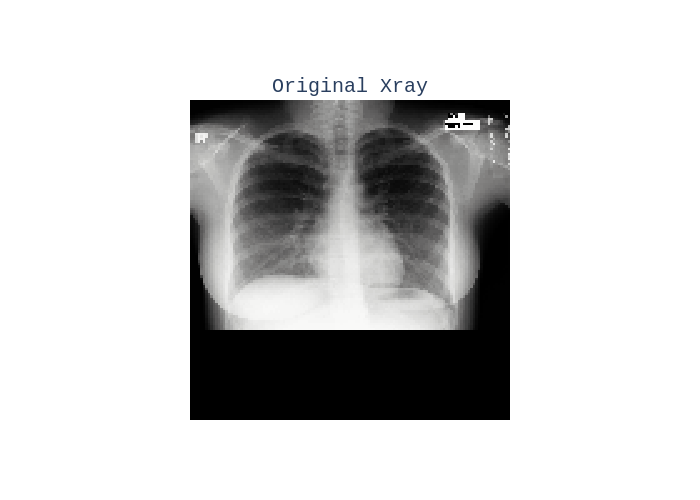

In [5]:
ImageDisplay(image=a["image"][0],title="Original Xray").show()

One can also use ImageDisplay to overlay a mask on the original image. 

Masks here must be 2-dimensional or 3-dimentional tensors. Tensors may be 3-dimensional with the channel dimension indicating multiple different masks. They may also be combined with label(s) if desired, as demonstrated below.

NOTE: In the below cells, the interactive mode has been turned off to reduce  the overall size of the notebook, but you can change this to True and experience the interactive visualization offered by FastEstimator

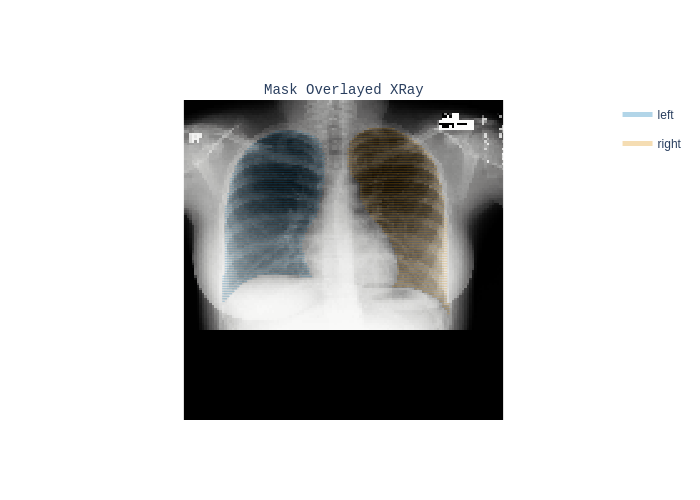

In [6]:
ImageDisplay(image=a["image"][0],
             masks=(a["mask"][0],['left','right']), 
             mask_threshold=0.5,
             title="Mask Overlayed XRay").show(interactive=False)

NOTE: In the cell above, notice that we set the parameter 'mask_threshold' to 0.5. This argument is optional, and is used to binarize masks. If it is set to NONE (the default) and continuous masks are provided then those masks will be rendered as a heatmap over the image. If continuous masks are used then mask labeling is not supported.

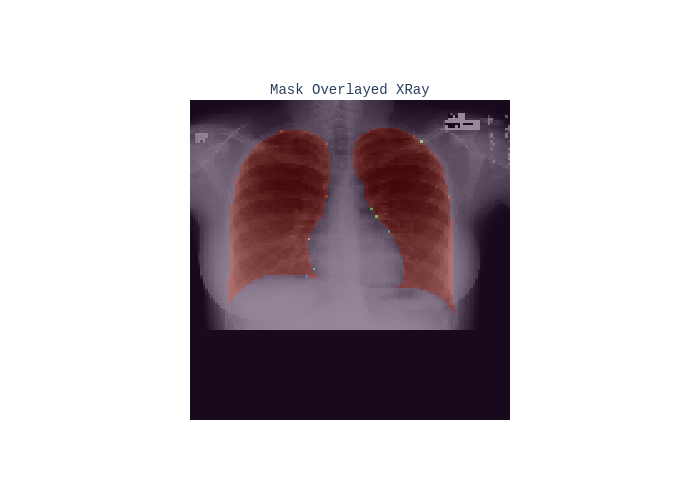

In [7]:
ImageDisplay(image=a["image"][0],
             masks=a["mask"][0],
             title="Mask Overlayed XRay").show(interactive=False)

One can also use ImageDisplay to overlay bounding box(es) on the original image. 

ImageDisplay accepts one or more bounding boxes of the form (x0, y0, width, height label), where (x0, y0) is the top left corner of the box. These may also be encoded in a tensor of shape (4,) or (N,4) for multiple boxes (in which case labels would be ommitted).

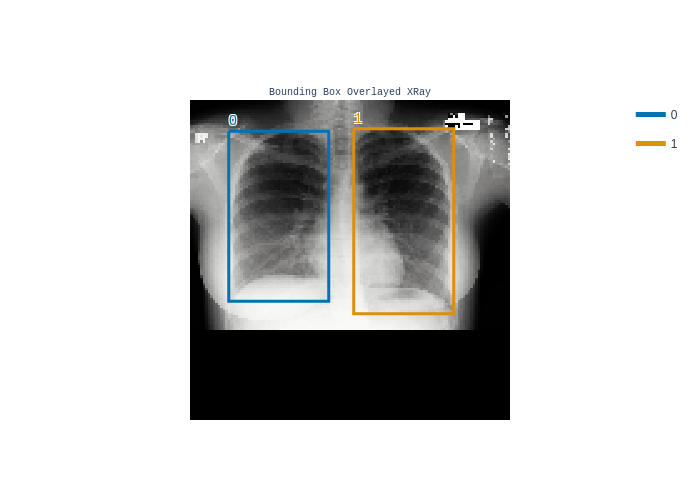

In [8]:
ImageDisplay(image=a["image"][0],
             bboxes= a["bbox_gt"][0],
             title="Bounding Box Overlayed XRay").show(interactive=False)

ImageDisplay can be used to overlay keypoints on  the original image.

Keypoints are expected to either be a 1D tensor of shape (2,) or to be a 2D tensor of shape (N,2) indicating multiple 1D keypoints. Similar to the masks, keypoints may be combined with label(s) if desired: (keypoint, label). 

NOTE : (x,y) coordinates of keypoints indicate distance from the top left of an image, with negative or None values indicating that a keypoint was not detected.

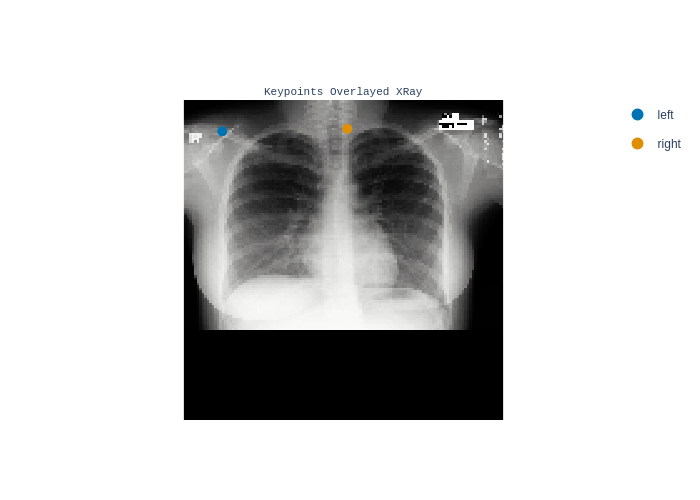

In [9]:
ImageDisplay(image=a["image"][0],
             keypoints= (a["keypoints"][0],['left','right']),
             title="Keypoints Overlayed XRay").show(interactive=False)

Let's see how they look together

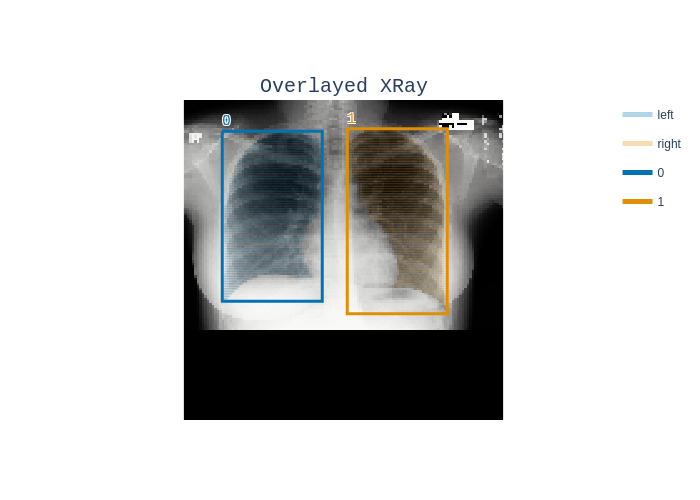

In [10]:
ImageDisplay(image=a["image"][0],
             masks=(a["mask"][0],['left','right']),
             bboxes= a["bbox_gt"][0], 
             mask_threshold=0.5,
             title="Overlayed XRay").show(interactive=False)

<a id='t12BatchDisplay'></a>

### BatchDisplay

BatchDisplay works the same way as ImageDisplay, the only difference being that it visualizes multiple samples from a Batch at the same time. Lets visualize an entire batch of data:

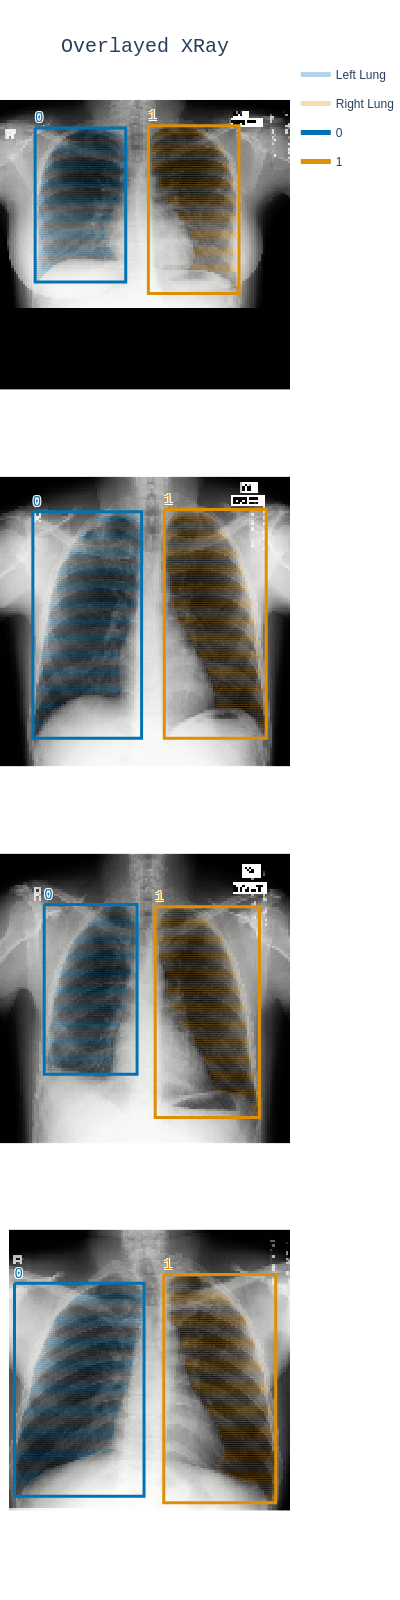

In [11]:
BatchDisplay(image=a["image"],
             masks=(a["mask"], ['Left Lung', 'Right Lung']),
             bboxes= a["bbox_gt"],
             mask_threshold=0.5,
             title="Overlayed XRay").show(interactive=False)

<a id='t12GridDisplay'></a>

### GridDisplay

We have seen how one can take advantage of ImageDisplay or BatchDisplay to improve their visualization experience. GridDisplay can further enhance this experience by placing the output of ImageDisplay or BatchDisplay into a multi-column grid.

NOTE: A GridDisplay can take ImageDisplays or BatchDisplays, but not a mixture of both at once.

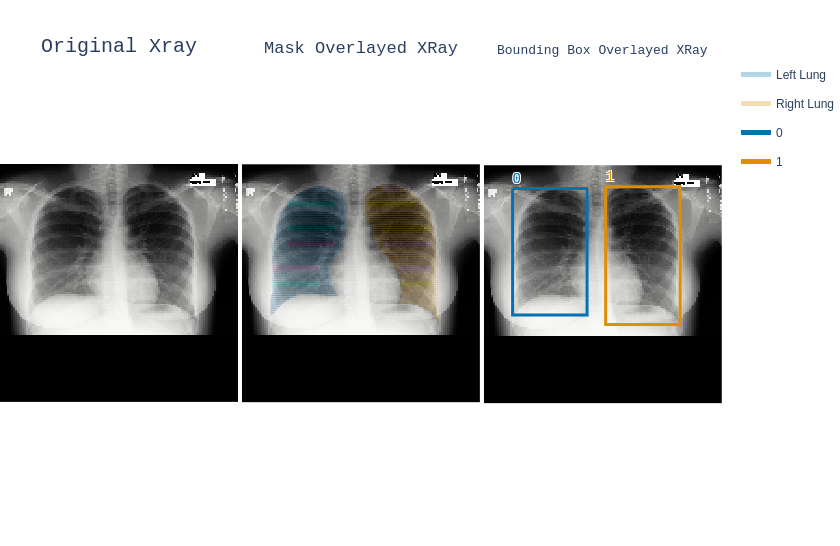

In [12]:
GridDisplay([ImageDisplay(image=a["image"][0],
                          title="Original Xray"), 
             ImageDisplay(image=a["image"][0],
                          masks=(a["mask"][0], ['Left Lung', 'Right Lung']),
                          mask_threshold=0.5,title="Mask Overlayed XRay"), 
             ImageDisplay(image=a["image"][0],
                          bboxes= a["bbox_gt"][0],
                          title="Bounding Box Overlayed XRay")
            ]).show(interactive=False)

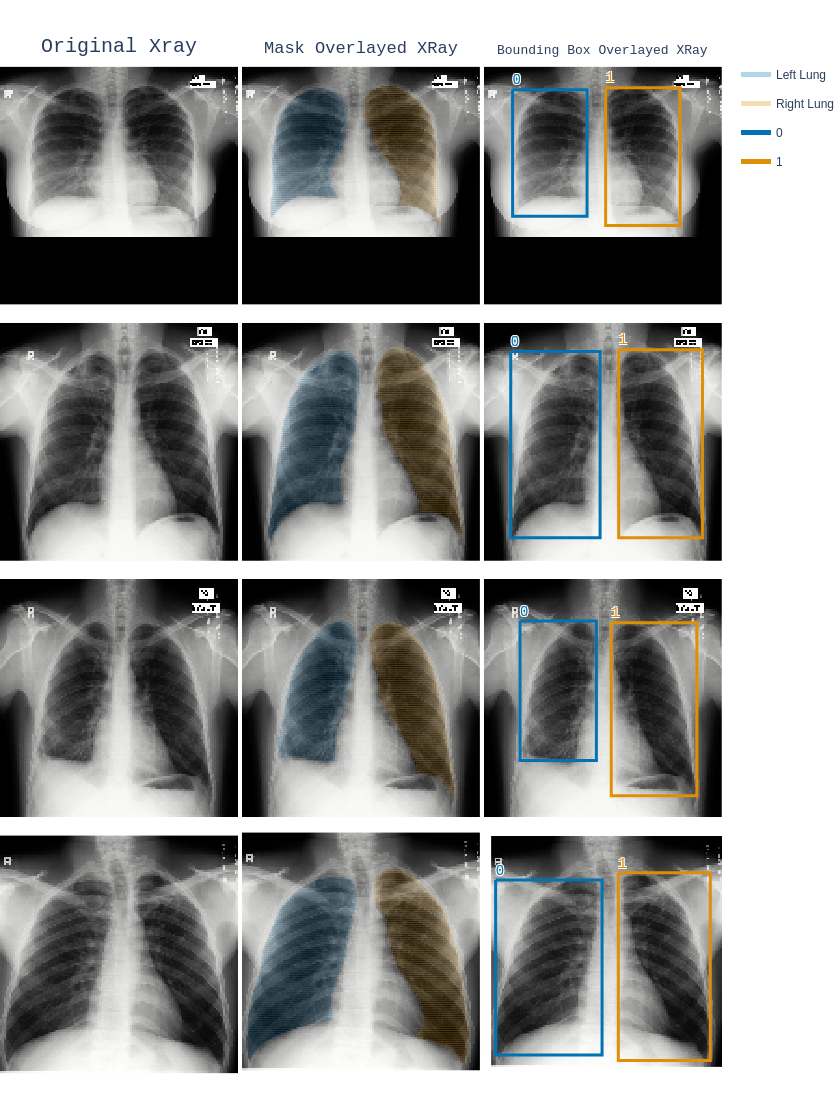

In [13]:
GridDisplay([BatchDisplay(image=a["image"],
                          title="Original Xray"), 
             BatchDisplay(image=a["image"],
                          masks=(a["mask"],['Left Lung', 'Right Lung']), 
                          mask_threshold=0.5,title="Mask Overlayed XRay"), 
             BatchDisplay(image=a["image"],
                          bboxes= a["bbox_gt"],
                          title="Bounding Box Overlayed XRay")
            ]).show(interactive=False)

<a id='t12DisplayTraces'></a>

## Display Traces

Along with these utility tools for visualization, FastEstimator also provides users with visualization traces. This provides users the opportunity to use the functionalities of BatchDisplay and GridDisplay to visualize model outputs while training.


In [14]:
model = fe.build(
    model_fn=lambda: UNet(input_size=(1, 128, 128), output_channel=2),
    optimizer_fn=lambda x: torch.optim.Adam(params=x, lr=0.0001),
    model_name="lung_segmentation"
)

network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    CrossEntropy(inputs=("pred_segment", "binary_mask"), outputs="loss", form="binary"),
    UpdateOp(model=model, loss_name="loss")
])

In [15]:
traces = [
    Dice(true_key="binary_mask", pred_key="pred_segment"),
    GridDisplayTrace([BatchDisplayTrace(image="image",
                                        title="Original Xray"), 
                      BatchDisplayTrace(image="image",
                                        masks="mask",
                                        mask_threshold=0.5,
                                        title="GT Mask Overlay"), 
                      BatchDisplayTrace(image="image",
                                        masks="pred_segment",
                                        mask_threshold=0.5,
                                        title="Prediction Mask Overlay")])]

In [16]:
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=2,
                         log_steps=20,
                         traces=traces,
                         train_steps_per_epoch=None,
                         eval_steps_per_epoch=None)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; logging_interval: 20; num_device: 1;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints
FastEstimator-Train: step: 1; loss: 0.68167776;


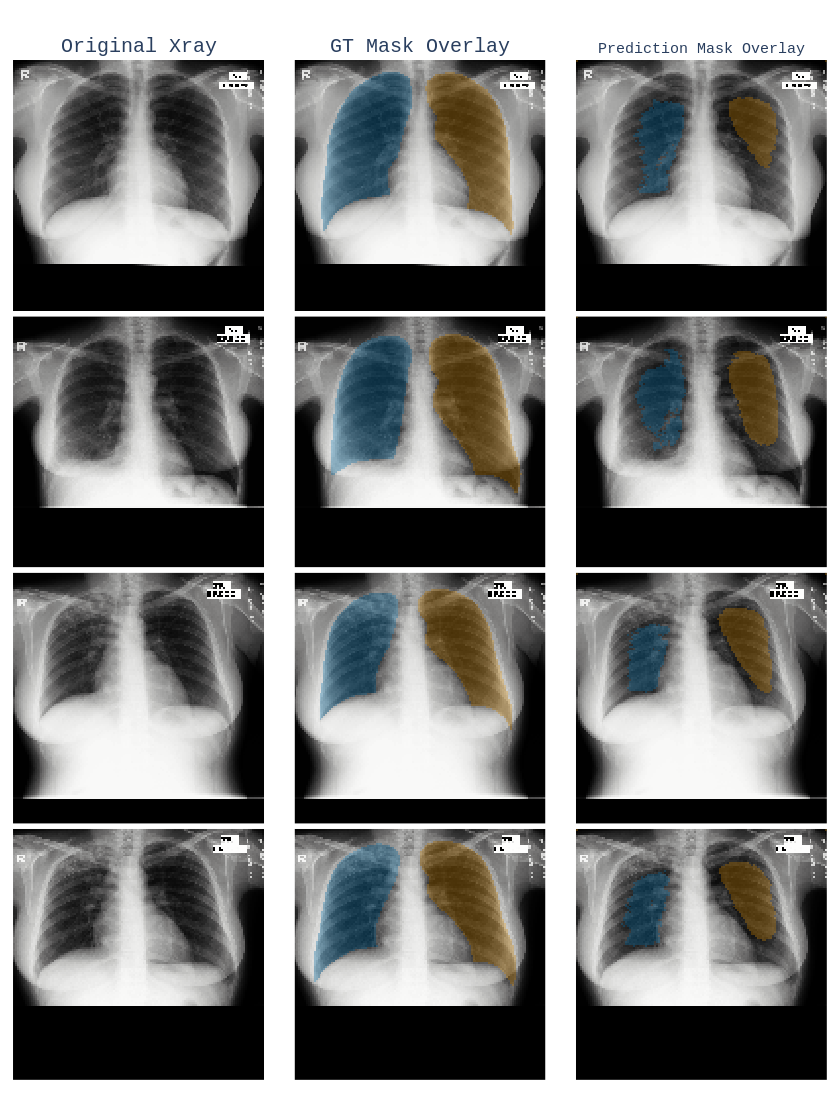

FastEstimator-Train: step: 20; loss: 0.17968386; steps/sec: 34.38;
FastEstimator-Train: step: 28; epoch: 1; epoch_time(sec): 13.61;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints
Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 1.19;
Eval Progress: 4/7; steps/sec: 1.65;
Eval Progress: 7/7; steps/sec: 3.55;
FastEstimator-Eval: step: 28; epoch: 1; Dice: 0.76438475; loss: 0.1285142;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints


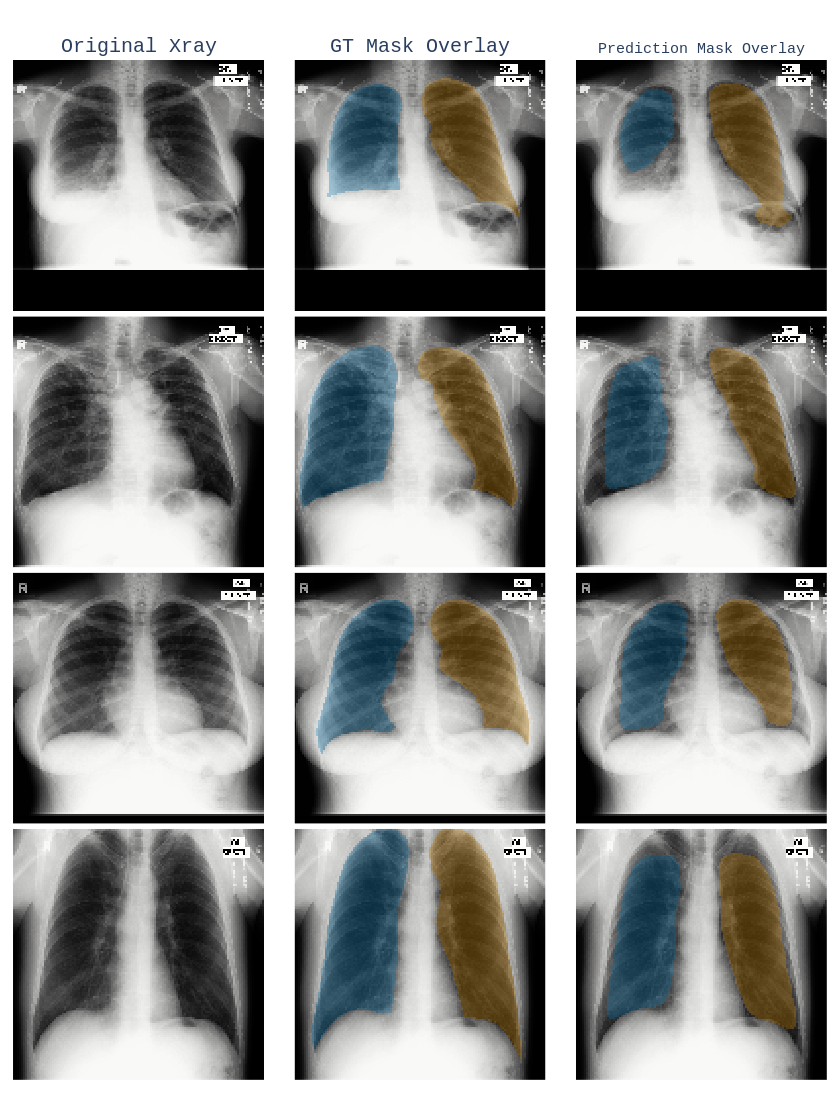

FastEstimator-Train: step: 40; loss: 0.12183587; steps/sec: 1.5;
FastEstimator-Train: step: 56; epoch: 2; epoch_time(sec): 13.02;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints
Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 1.22;
Eval Progress: 4/7; steps/sec: 1.86;
Eval Progress: 7/7; steps/sec: 3.69;
FastEstimator-Eval: step: 56; epoch: 2; Dice: 0.9235015; loss: 0.056964148;
FastEstimator-Finish: step: 56; lung_segmentation_lr: 0.0001; total_time(sec): 43.81;


In [17]:
estimator.fit()
